<a href="https://colab.research.google.com/github/ExCaLBBR/ExCaLBBR_Projects/blob/main/GeometryBasedDecisions/code/GeoBasedDecisions_AnalysisPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Media Consumption and Identity based Concept Geometries Predict Engagement and Beliefs Towards Societal Institutions
<b>Active project: [OSF Link](https://osf.io/vj7e5/)</b><br><br>
Authors: <b>Dr. Roberto Vargas; Ash Gelber; Dr. Timothy Verstynen </b><br>
Codebook created by: <b>Roberto Vargas </b><br>
<br>
<b>Pipeline includes:</b><br>
*   Data restructuring: Sorting accoring to word list
*   Replication of previous work:
 *  Regression predicting pair edged using: <i>Race; Gender; Income; Age; NewsBias</i>
 *   Mediation analysis
*    Edge-wise predictions of agreement: <i>mantel's boostrapping; permutation testing</i>

<br>
<br>

In [10]:
#@title Install dependancies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import scipy
from scipy import stats
from scipy.stats import t
from scipy.stats import entropy
from scipy.stats import norm
from collections import Counter
from itertools import combinations
from itertools import compress
import math
import statsmodels.formula.api as smf
import statsmodels as sm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import csv
from tqdm import tqdm
import requests
import os
import re
import warnings
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.feature_selection import SelectKBest, f_classif
# from scipy.stats import ttest_ind
# import geopandas as gpd
# !pip install census --quiet
# !pip install us --quiet
# from census import Census
# from us import states

In [2]:
#@title Define utility functions
def weightedHeatmap(PairData, words, PlotHM, Title, cbarLab):

    '''
    Restructure RT into matrix data structure

    '''

    Wmat = np.zeros((len(words),len(words)))
    t = 0
    z = 0

    for i in range(len(words)):
        for j in range(len(words)):
            if i == j:
#                Wmat[i,j] = np.NaN
                Wmat[i,j] = 7
            elif j > i:
                Wmat[i,j] = PairData[t]
                Wmat[j,i] = PairData[t]
                t += 1

    if PlotHM == 1:
      ax = plt.gca()
      im = ax.imshow(Wmat, cmap = 'RdBu', vmin=-7, vmax=7)
      cbar = ax.figure.colorbar(im, ax = ax, shrink=0.7)
      cbar.ax.set_ylabel(cbarLab, rotation = -90, va = "bottom")
      ax.set_xticks(np.arange(Wmat.shape[1]), labels = words, size=15)
      ax.set_yticks(np.arange(Wmat.shape[0]), labels = words, size=15)
      ax.tick_params(top = True, bottom = False, labeltop = True, labelbottom = False)
      plt.setp(ax.get_xticklabels(), rotation = -45, ha = "right", rotation_mode = "anchor", size=15)
      #ax.spines[:].set_visible(False)
      ax.set_xticks(np.arange(Wmat.shape[1] + 1) - 0.5, minor = True)
      ax.set_yticks(np.arange(Wmat.shape[0] + 1) - 0.5, minor = True)
      ax.grid(which = "minor", color = "black", linestyle = '-', linewidth = 1)
      ax.tick_params(which =  "minor", bottom = False, left = False)
      ax.set_title(Title)
      plt.show()
    return Wmat


def item_randperm(size, perm):
    # Generate perm random permutations
    return np.array([np.random.permutation(size) for _ in range(perm)], dtype=int)

def splitHalf_Reliability(dat, perm):
    '''
    Compute the reliability within a measure
    This analysis splits the data into 2 halfs and then averages the similarity structure
    This analysis is repeated
    '''

    pSplit = item_randperm(dat.shape[1], perm)

    rho = []
    for p in range(perm):
        # Split data
        if dat.shape[1] % 2 == 0:  # is even
            frstHalf = dat.iloc[:, pSplit[p, :(pSplit.shape[1]//2)]]
            scndHalf = dat.iloc[:, pSplit[p, (pSplit.shape[1]//2):]]

        elif dat.shape[1] % 2 == 1:  # is odd
            frstHalf = dat.iloc[:, pSplit[p, :int(np.floor(pSplit.shape[1]/2))]]
            scndHalf = dat.iloc[:, pSplit[p, int(np.ceil(pSplit.shape[1]/2)):]]
        # Avg dist of each half
        avgFrstHalf = frstHalf.mean(axis=1)
        avgScndHalf = scndHalf.mean(axis=1)

        # Correlate halves
        rhoI = np.corrcoef(avgFrstHalf, avgScndHalf)[0,1]
        rho.append(rhoI)

    rho = np.mean(rho)

    return rho



def regPairDiff(X, Y, perm):
    '''
    Predict pair differences among X in Y
    X is a vector or matrix of variables used to predict Y
    Y is a continuous vector
    perm is the number of permutations used to compare against the observed beta
    Dimensions of X and Y should all align
    '''
    # Ensure inputs are numeric
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.float64)

    # Generate the permutations
    pComb = item_randperm_v2(X.shape[0], perm)

    # Add a constant term for the model
    xModel = np.hstack((np.ones((X.shape[0], 1)), X)).astype(np.float64)

    # Estimate observed beta
    betaObs = np.linalg.lstsq(xModel, Y, rcond=None)[0]

    # Precompute permuted Y matrices
    permuted_Ys = Y[pComb]

    # Compute betas for all permutations in a vectorized manner
    betaPerm = np.linalg.lstsq(xModel, permuted_Ys.T, rcond=None)[0].T

    # Convert betaPerm to DataFrame for compatibility with the original output
    betaPerm = pd.DataFrame(betaPerm)

    # Compute p-values
    betaObs_signs = np.sign(betaObs)  # Determine positive/negative direction
    pval = []

    for b, beta_obs in enumerate(betaObs):
        if beta_obs == 0:
            raise ValueError("Observed beta is exactly equal to 0")

        # Vectorized comparison
        nBbeyond = (
            np.sum(betaPerm.iloc[:, b] * betaObs_signs[b] > beta_obs * betaObs_signs[b])
        )
        pb = (nBbeyond + 1) / perm
        pval.append(pb)

    return betaObs, pval, betaPerm

def mediation(x, m, y):
  '''
  Predict pair differences among a X in Y and the extent which this effect is mediated by m
 	X is vector used to predict Y
  m is a mediator
 	Y is a continuous vector
  '''
  import statsmodels.api as sm
  #Test effect of X on Y
  X = pd.DataFrame({'Intercept':np.ones(len(x)),'X':x})
  lm1 = sm.OLS(y,X).fit()
  ec = lm1.params[1] # save total effect c to ec

  #Test effect of X on M
  lm2 = sm.OLS(m,X).fit()
  ea = lm2.params[1] # Save the effect of X on M, a, to ea
  sea = lm2.bse[1]

  #Test effect of X and M on Y
  X['M'] = m
  lm3 = sm.OLS(y,X).fit()
  ecq,eb = lm3.params[1:3]
  seb = lm3.bse[2]

  toteff = ec # Total effect
  XM = ea #coef from x to m
  MY = eb #coef from m to y
  XMse = sea #standard error from x to m
  MYse = seb #standard error from m to y
  medeff = ea*eb #Indirect mediated effect
  direff = ecq #Direct effect
  sumeff = medeff + direff #sum of effect
  return toteff, medeff, direff, sumeff, XM, MY, XMse, MYse


def mediationPerm(x, m, y, perm):
    '''
    Predict pair differences among a X in Y and the extent which this effect is mediated by m.
    X is vector used to predict Y
    m is a mediator
    Y is a continuous vector
    perm is the number of permutations used to compare against the observed beta
    Dimensions of X, m, and Y should all align.
    '''
    # Precompute observed values
    toteff_obs, medeff_obs, direff_obs, sumeff_obs, XM_obs, MY_obs, XMse_obs, MYse_obs = mediation(x, m, y)
    t_obs, _ = sobel_test(XM_obs, MY_obs, XMse_obs, MYse_obs)

    # Generate permutations
    pComb = np.array([np.random.permutation(len(y)) for _ in range(perm)])

    # Compute effects for permutations
    def perm_effects(y_perm):
        toteff, medeff, direff, sumeff, XM, MY, XMse, MYse = mediation(x, m, y_perm)
        t_perm, _ = sobel_test(XM, MY, XMse, MYse)
        return toteff, medeff, direff, sumeff, t_perm

    perm_results = [perm_effects(y[pComb[i]]) for i in range(perm)]
    toteff_perm, medeff_perm, direff_perm, sumeff_perm, medt_perm = zip(*perm_results)

    # Convert to numpy arrays for vectorized comparison
    toteff_perm = np.array(toteff_perm)
    medeff_perm = np.array(medeff_perm)
    direff_perm = np.array(direff_perm)
    sumeff_perm = np.array(sumeff_perm)
    medt_perm = np.array(medt_perm)

    # Calculate p-values
    def compute_pval(observed, permuted):
        if observed > 0:
            return np.mean(permuted > observed)
        elif observed < 0:
            return np.mean(permuted < observed)
        else:
            raise ValueError('Observed value is exactly equal to 0')

    pval_tot = compute_pval(toteff_obs, toteff_perm)
    pval_med = compute_pval(medeff_obs, medeff_perm)
    pval_dir = compute_pval(direff_obs, direff_perm)
    pval_sum = compute_pval(sumeff_obs, sumeff_perm)
    pval_sobelT = compute_pval(t_obs, medt_perm)

    # Prepare results
    ObsEff = pd.DataFrame({
        'TotEff': [toteff_obs],
        'MedEff': [medeff_obs],
        'DirEff': [direff_obs],
        'SumEff': [sumeff_obs],
        'SobelT': [t_obs]
    })

    pval = pd.DataFrame({
        'Totpval': [pval_tot],
        'Medpval': [pval_med],
        'Dirpval': [pval_dir],
        'Sumpval': [pval_sum],
        'SobelTpval': [pval_sobelT]
    })

    return ObsEff, pval

def sobel_test(a, b, se_a, se_b):
    '''
    Sobel test for significance of mediation

    Args:
        a: coefficient from X to mediator variable, M
        b: coefficient from M to Y
        se_a: Standard error of A
        se_b: Standard error fo B

    Returns:
        t: Sobel's test statistic
        pval : Two-tailed probability assuming normal distribution
    '''

    SE = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2))
    t = (a*b) / SE
    n = 100000000
    pval = stats.t.sf(np.abs(t), n-1)*2
    return t, pval


def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + numpy.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # search bounds for a
    parameterBounds.append([minX, maxX]) # search bounds for b
    parameterBounds.append([0.0, maxY]) # search bounds for Offset

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x


##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

In [3]:
#@title Load data, Sort trial randomization into intuitive structure
#Data path
path = 'https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/GeometryBasedDecisions/'

# Load Demographic PRaM data
datDemo = pd.read_csv (path + 'data/df_demographic.csv', header=0) #Demograpic info
datPRaM = pd.read_csv (path + 'data/df_taskPRaM.csv', header=0) #PRaM Data
pairLab = pd.read_csv (path + 'data/PRaM_pairLabels.csv', header=None) #List of pair labels
trialConceptLabels = pd.read_csv (path + 'data/df_trialConceptLabels.csv', header=0) #pair labels as they exist in study
newsOrdinal = pd.read_excel (path + 'data/df_newsCoded_ordinal_AllSides_11-2024.xlsx', header=0) #News consumption bias data ordinalized
newsHiRes = pd.read_excel (path + 'data/df_newsCoded_highRes.xlsx', header=0) #News consumption bias data ordinalized

#Identify participants who did not complete all measures
lst1 = datDemo['ParticipantID']
lst2 = newsOrdinal['Participant ID']
exPart = list(set(lst1) - set(lst2)) #No Participants differ between start and end of study

#Sort pairs accoring to prefered combination [This will be helpful for later vizualizations]
words = ['police', 'firefighter', 'neighbors(yours)', 'conservatives(political)', 'liberals(political)', 'healthcare', 'voting', 'immigration', 'religion', 'science', 'anger', 'fear', 'joy', 'love', 'sadness', 'trust']
combinations_list = [list(c) for c in combinations(words, 2)]

#Standardize order and Left-right position of concepts: generate new sorted data frame
PairLabel = []    #AB order of concepts for each of interpretations
allPairIdx = []   #index orders are saved as list
for i in range(len(combinations_list)):

  PairLabelAB = combinations_list[i][0] + '-' + combinations_list[i][1]
  PairLabelBA = combinations_list[i][1] + '-' + combinations_list[i][0]

  if PairLabelAB in datPRaM:
    PairLabeli = PairLabelAB
  elif PairLabelBA in datPRaM:
    PairLabeli = PairLabelBA
  else:
    print('Error: The concept pair in the combination list does not exist in dataset')

  pairIdx = datPRaM.columns.get_loc(PairLabeli)
  PairLabel.append(PairLabelAB) #For each of interpretation of future vizualizations we always use the AB structure
  allPairIdx.append(pairIdx)

# Pair label rating
datPRaM_conSort = datPRaM.iloc[:,allPairIdx]
datPRaM_conSort = datPRaM_conSort.rename(columns=dict(zip(datPRaM_conSort.columns, PairLabel)))
PairLabel = pd.DataFrame(PairLabel)

In [4]:
#@title Compute left/right simulus presentation statistics
fullLeftList = trialConceptLabels['conceptLeft']

wLeftPerc = []
for w in words:
  leftTally = [t for t in fullLeftList if t == w]
  wLeftPerc.append((len(leftTally)/(len(words)-1))*100)
print('mean probability of left position = ', np.mean(wLeftPerc))
print('The probabilities range from', min(wLeftPerc), 'to', max(wLeftPerc))

mean probability of left position =  50.0
The probabilities range from 40.0 to 53.333333333333336


In [5]:
#@title Identify mono Racial and M/F Gender identity participants

# Isolate mono racial White and Black participants and extract booleans for each group and combine
WhiteP = datDemo['White']==1
BlackP = datDemo['Black or African American']==1
monoWhiteP = (datDemo['White']==1) & (datDemo['American Indian or Alaskan Native'] + datDemo['Asian'] + datDemo['Native Hawaiian or other Pacific Islander'] + datDemo['Black or African American'] ==0) #= 293
monoBlackP = (datDemo['Black or African American']==1) & (datDemo['American Indian or Alaskan Native'] + datDemo['Asian'] + datDemo['Native Hawaiian or other Pacific Islander'] + datDemo['White'] ==0) #= 290
monoRaceP = np.logical_or(monoWhiteP, monoBlackP) #Use this boolean in conjunction  with other partiicpant filters

totalN = len(datDemo.index) # N = 599 pariticpants completed the study
WhitePN = WhiteP.values.sum() # N = 304 (Includes multiracial folk)
BlackPN = BlackP.values.sum() # N = 300 (Includes multiracial fold)
monoWhitePN = monoWhiteP.values.sum() # N = 293
monoBlackPN = monoBlackP.values.sum() # N = 290
monoRacePN = monoRaceP.values.sum() # N = 583
mRIdx = [i for i, x in enumerate(monoRaceP) if x] #index of monoRace participants

# Isolate participants who only identify as either Male of Female genders
femaleP = datDemo['Gender'] == 'Female'
maleP  = datDemo['Gender'] == 'Male'
mfP = np.logical_or(femaleP, maleP)
femalePN = femaleP.values.sum() # N = 300
malePN = maleP.values.sum() # N = 298
mfPN = mfP.values.sum()
mfIdx = [i for i, x in enumerate(mfP) if x] #index of monoRace participants

#Create index to subset master files
relevantIdentity = np.logical_and(monoRaceP, mfP) #Boolean of participants who identify as monoRace and Male or Female genders
relevantIdentityN = relevantIdentity.values.sum() # N = 582
relevantIdentityIdx = [i for i, x in enumerate(relevantIdentity) if x] # create index for participants who identify as monoRace or Male or Female genders

#Subset relevant data sets: mRmfG suffix refers to only the participants who  identify as monoRace and Male or Female genders
datDemo_mRmfG = datDemo.iloc[relevantIdentityIdx,:]
PRaM_mRmfG = datPRaM_conSort.iloc[relevantIdentityIdx,:]
Age_mRmfG = datDemo_mRmfG['DoB_year']
Income_mRmfG = datDemo_mRmfG['partIncome']
Edu_mRmfG = datDemo_mRmfG['partEdu']
gender_mRmfG = datDemo_mRmfG['Gender']
NewsOrd_mRmfG = newsOrdinal.iloc[relevantIdentityIdx,:]
NewsHiRes_mRmfG = newsHiRes.iloc[relevantIdentityIdx,:]
avgNewsOrd_mRmfG = NewsOrd_mRmfG['Average']
avgNewsHiRes_mRmfG = NewsHiRes_mRmfG['Average']
blackCoded_mRmfG = datDemo_mRmfG['Black or African American'] #Create dummy code so Black ID = 1; White = 0

#Generate dummy coded variables
#Gender recoding
rep = {"Female": 1, "Male": 0}; genderCoded_mRmfG = gender_mRmfG #Define coded variable and specify dummy code replacements
for key, value in rep.items():
    genderCoded_mRmfG = genderCoded_mRmfG.replace(key, str(value)) #replace strings with codes

#Income
#Edu


#Find participants with non-algorithmic news consumption
nonAlgNewsMask = avgNewsOrd_mRmfG != 'x' #Create mask for non alforithmic news
nonAlgNewsN = nonAlgNewsMask.values.sum() # N = 298
nonAlgNewsIdx = [i for i, x in enumerate(nonAlgNewsMask) if x] # Create list of indecies

#Subset relevant data sets adding the additional non Algorthimic news mask. This will be the sets used for most of the analyses moving forward
datDemo_mRmfGnaN = datDemo_mRmfG.iloc[nonAlgNewsIdx,:]
PRaM_mRmfGnaN = PRaM_mRmfG.iloc[nonAlgNewsIdx,:]
blackCoded_mRmfGnaN = blackCoded_mRmfG.iloc[nonAlgNewsIdx]
Age_mRmfGnaN = Age_mRmfG.iloc[nonAlgNewsIdx]
Income_mRmfGnaN = Income_mRmfG.iloc[nonAlgNewsIdx]
Edu_mRmfGnaN = Edu_mRmfG.iloc[nonAlgNewsIdx]
genderCoded_mRmfGnaN = genderCoded_mRmfG.iloc[nonAlgNewsIdx]
NewsOrd_mRmfGnaN = avgNewsOrd_mRmfG.iloc[nonAlgNewsIdx]
NewsHRes_mRmfGnaN = avgNewsHiRes_mRmfG.iloc[nonAlgNewsIdx]


print(f'Sample of participant completing session = ', totalN)
print(f'Of',totalN, ',' ,monoRacePN, 'participants identified as non-Hispanic White(', monoWhitePN,') or Black/AfricanAmerican(', monoBlackPN,')')
print(f'of', totalN, ',', mfPN, 'participants identified as Female(', femalePN, ') or Male(', malePN,')')
print(f'The total sample that fits the target population of nonHispanic White or Black/AfricanAmerican and Male or Female identifying participants = ', relevantIdentityN)
print(f'of the', relevantIdentityN, ',', nonAlgNewsN, 'participants consumed a non-algorithmic news source with measurable political bias.')
print(f'The final analyzed sample contains', nonAlgNewsN, 'participants!')

Sample of participant completing session =  599
Of 599 , 583 participants identified as non-Hispanic White( 293 ) or Black/AfricanAmerican( 290 )
of 599 , 598 participants identified as Female( 300 ) or Male( 298 )
The total sample that fits the target population of nonHispanic White or Black/AfricanAmerican and Male or Female identifying participants =  582
of the 582 , 485 participants consumed a non-algorithmic news source with measurable political bias.
The final analyzed sample contains 485 participants!


In [6]:
3#title May be used for future analysis
#Isolate Zip variable
# zipBornCol = datDemo.columns.get_loc('zipborn')
# bZipBorn = datDemo.iloc[bIndx,zipBornCol]
# wZipBorn = datDemo.iloc[wIndx,zipBornCol]
# zipBorn = np.concatenate([bZipBorn, wZipBorn])

# zip10yCol = datDemo.columns.get_loc('response-3')
# bZip10y = datDemo.iloc[bIndx,zip10yCol]
# wZip10y = datDemo.iloc[wIndx,zip10yCol]
# zip10y = np.concatenate([bZip10y, wZip10y])

# zipNowCol= datDemo.columns.get_loc('zipnow')
# bZipNow = datDemo.iloc[bIndx,zipNowCol]
# wZipNow = datDemo.iloc[wIndx,zipNowCol]
# zipNow = np.concatenate([bZipNow, wZipNow])

3

In [7]:
#@title Code data according to old pipeline for easy running
PRaM_nGnANB = PRaM_mRmfGnaN
Gender_nGnANB = genderCoded_mRmfGnaN
blackCode_nGnANB = blackCoded_mRmfGnaN
NewsBias_nGnANB = NewsOrd_mRmfGnaN
#NewsBias_nGnANB = NewsHRes_mRmfGnaN
Age_nGnANB = Age_mRmfGnaN
Income_nGnANB = Income_mRmfGnaN
bIndx_nGnANB = blackCode_nGnANB == 1
wIndx_nGnANB = blackCode_nGnANB == 0
PRaM_nGnANB = PRaM_nGnANB.to_numpy()

The sample is 0.0 % Female and 100.0 % Male
The sample is 50.52 % Black and 49.48 % White
Mean age for sample: 37.17 ( SD = 11.83 )


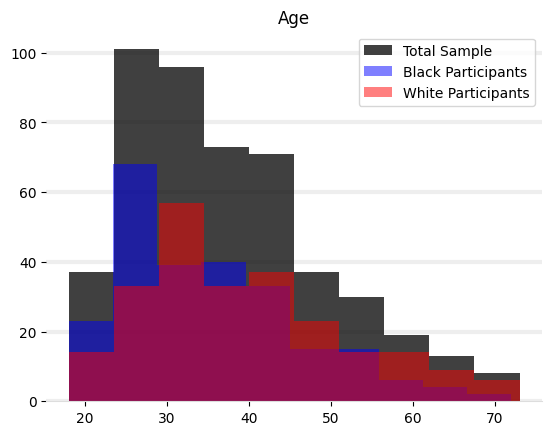

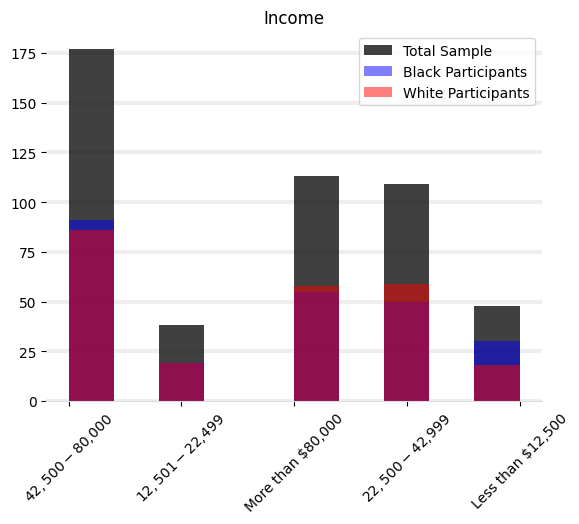

Mean News consumption bias for sample: 2.61 ( SD = 0.99 ; 1=Left & 3=Center & 5=Right)
Mean News consumption bias for White Participants: 2.68 ( SD = 1.09 ; 1=Left & 3=Center & 5=Right)
Mean News consumption bias for Black Participants: 2.55 ( SD = 0.87 ; 1=Left & 3=Center & 5=Right)


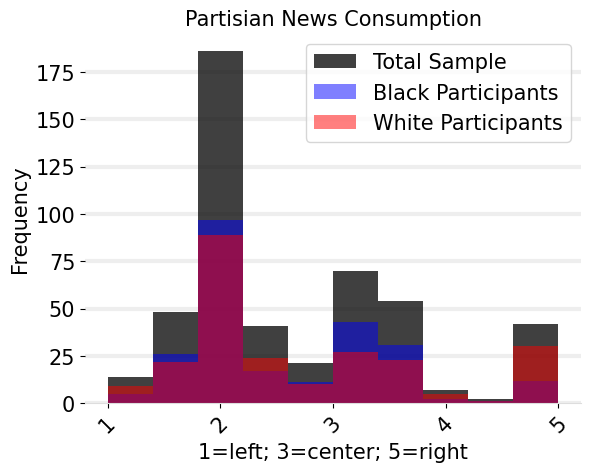

In [8]:
#@title Plot descriptive statistics
#Report Gender breakdown
propFemale = (sum(Gender_nGnANB==1)/len(Gender_nGnANB))*100
propFemale = round(propFemale,2)
print('The sample is',propFemale, '% Female and', (100-propFemale),'% Male')

#Report racial breakdown
propBlack = (sum(blackCode_nGnANB==1)/len(blackCode_nGnANB))*100
propBlack = round(propBlack,2)
print('The sample is',propBlack, '% Black and', (100-propBlack),'% White')

#Create race masks
bIndx_nGnANB = blackCode_nGnANB == 1
wIndx_nGnANB = blackCode_nGnANB == 0

# Plot age histograms
Age_mean = np.mean(Age_nGnANB)
Age_sd = np.std(Age_nGnANB)
print(f'Mean age for sample:', round(Age_mean,2), '( SD =', round(Age_sd,2), ')')
fig, ax = plt.subplots()
plt.hist(Age_nGnANB, alpha=0.75, color= 'k')
plt.hist(Age_nGnANB[bIndx_nGnANB], alpha=0.5, color= 'b')
plt.hist(Age_nGnANB[wIndx_nGnANB], alpha=0.5, color= 'r')
plt.title('Age')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
labels= ["Total Sample","Black Participants", "White Participants"]
plt.legend(labels)
plt.show()

# Plot Income histograms
fig, ax = plt.subplots()
customSort = {'Less than $12500':0, '$12501-$22500':1, '$22501-$42500':2, '$42501-$80000':3 ,'More than $80000':4}
IncPlot = Income_nGnANB.sort_values(key=lambda x: x.map(customSort))
bIncPlot = Income_nGnANB[bIndx_nGnANB].sort_values(key=lambda x: x.map(customSort))
wIncPlot = Income_nGnANB[wIndx_nGnANB].sort_values(key=lambda x: x.map(customSort))
plt.hist(IncPlot, alpha=0.75, color='k')
plt.hist(bIncPlot, alpha=0.5, color='b')
plt.hist(wIncPlot, alpha=0.5, color='r')
plt.title('Income')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
plt.xticks(rotation = 45)
plt.legend(["Total Sample","Black Participants", "White Participants"])
plt.show()

# Plot NewsBias histograms
Newsbias_mean = np.mean(NewsBias_nGnANB)
Newsbias_sd = np.std(NewsBias_nGnANB)
Newsbias_mean_White = np.mean(NewsBias_nGnANB[wIndx_nGnANB])
Newsbias_sd_White = np.std(NewsBias_nGnANB[wIndx_nGnANB])
Newsbias_mean_Black = np.mean(NewsBias_nGnANB[bIndx_nGnANB])
Newsbias_sd_Black = np.std(NewsBias_nGnANB[bIndx_nGnANB])
print(f'Mean News consumption bias for sample:', round(Newsbias_mean,2), '( SD =', round(Newsbias_sd,2), '; 1=Left & 3=Center & 5=Right)')
print(f'Mean News consumption bias for White Participants:', round(Newsbias_mean_White,2), '( SD =', round(Newsbias_sd_White,2), '; 1=Left & 3=Center & 5=Right)')
print(f'Mean News consumption bias for Black Participants:', round(Newsbias_mean_Black,2), '( SD =', round(Newsbias_sd_Black,2), '; 1=Left & 3=Center & 5=Right)')

fig, ax = plt.subplots()
plt.hist(NewsBias_nGnANB.sort_values(axis=0), alpha=0.75, color='k')
plt.hist(NewsBias_nGnANB[bIndx_nGnANB].sort_values(axis=0), alpha=0.5, color='b')
plt.hist(NewsBias_nGnANB[wIndx_nGnANB].sort_values(axis=0), alpha=0.5, color='r')
plt.title('Partisian News Consumption', size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
plt.xlabel('1=left; 3=center; 5=right', size=15) #for ordinal
#plt.xlabel('5=left max; 0=center; 5=right max', size=15) #for hires
plt.ylabel('Frequency', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
labels= ["Total Sample","Black Participants", "White Participants"]
plt.legend(labels, prop={'size': 15})

plt.xticks(rotation = 45)
plt.show()

In [11]:
# @title Descriptive analysis of PRaM
#Subset data for Black and White Participants
bPRaM_nGnANB = PRaM_nGnANB[bIndx_nGnANB,:]
wPRaM_nGnANB = PRaM_nGnANB[wIndx_nGnANB,:]


# Average pair distance
avgDist = np.mean(PRaM_nGnANB, axis=0)
avgBDist = np.mean(bPRaM_nGnANB, axis=0)
avgWDist = np.mean(wPRaM_nGnANB, axis=0)

#Participant-wise normalization
PRaMz = stats.zscore(PRaM_nGnANB, axis=0)
bPRaMz = stats.zscore(bPRaM_nGnANB, axis=0)
wPRaMz = stats.zscore(wPRaM_nGnANB, axis=0)

#Convert to dataframes for Reliabiltiy calc
PRaMz = pd.DataFrame(PRaMz)
bPRaMz = pd.DataFrame(bPRaMz)
wPRaMz = pd.DataFrame(wPRaMz)

# Splithalf Reliability
perm = 10000
rhoPRaM = splitHalf_Reliability(PRaMz, perm)
rhobPRaM = splitHalf_Reliability(bPRaMz, perm)
rhowPRaM = splitHalf_Reliability(wPRaMz, perm)
print(f'PRaM reliability for Total sample:', round(rhoPRaM,2))
print(f'PRaM reliability for Black sample:', round(rhobPRaM,2))
print(f'PRaM reliability for White sample:', round(rhowPRaM,2))

# Generate distance matricies
bPRaM_Weights = weightedHeatmap(avgBDist, words,1, "Concept-Pair association for Black Participants", 'Blue=related; Red=Anti-related'); # Compute association matrix for Black participants
wPRaM_Weights = weightedHeatmap(avgWDist, words,1, "Concept-Pair association for White Participants", 'Blue=related; Red=Anti-related'); # Compute association matrix for White participants
diffPRaM_Weights = weightedHeatmap((avgBDist-avgWDist), words,1, "Concept-Pair association difference (Black-White)", 'Blue=related; Red=Anti-related'); # Compute association matrix for Black-White differences

KeyboardInterrupt: 

In [12]:
# @title Reset index and reshape for concatonation

#Income [Higher value means higher income bracket] [Note: This is coming later for plot formatting purposes]
i0Ind = Income_nGnANB.str.contains(pat = 'Less than $12,500', case=False, regex=False)
i1Ind = Income_nGnANB.str.contains(pat = '$12,501-$22,499', case=False, regex=False)
i2Ind = Income_nGnANB.str.contains(pat = '$22,500-$42,999', case=False, regex=False)
i3Ind = Income_nGnANB.str.contains(pat = '$42,500-$80,000', case=False, regex=False)
i4Ind = Income_nGnANB.str.contains(pat = 'More than $80,000', case=False, regex=False)
Income_nGnANB.loc[i0Ind] = 0
Income_nGnANB.loc[i1Ind] = 1
Income_nGnANB.loc[i2Ind] = 2
Income_nGnANB.loc[i3Ind] = 3
Income_nGnANB.loc[i4Ind] = 4
Income_nGnANB = Income_nGnANB


#Simplify variable  names
blackCoded = blackCode_nGnANB
femaleCoded = Gender_nGnANB
Income = Income_nGnANB
Age = Age_nGnANB
NewsBias = NewsBias_nGnANB

#Reset index for series (just in case)
blackCoded = blackCoded.reset_index(drop=True)
blackCoded = blackCoded.to_numpy() #convert series to array
femaleCoded = femaleCoded.reset_index(drop=True)
femaleCoded = femaleCoded.to_numpy() #convert series to array
Income = Income.reset_index(drop=True)
Income = Income.to_numpy()  #convert series to array
Age = Age.reset_index(drop=True)
Age = Age.to_numpy()  #convert series to array
NewsBias = NewsBias.reset_index(drop=True)
NewsBias = NewsBias.to_numpy()  #convert series to array

#Reshape for concatenation
blackCoded =  blackCoded.reshape(blackCoded.shape[0],1)
femaleCoded =  femaleCoded.reshape(femaleCoded.shape[0],1)
Income =  Income.reshape(Income.shape[0],1)
Age =  Age.reshape(Age.shape[0],1)
NewsBias = NewsBias.reshape(NewsBias.shape[0],1)

In [13]:
# @title Convert similarity ratings to edge distances
PRaM_edge = 1-(PRaM_nGnANB-(-7))/(7-(-7)) #Normalize each similarity rating between 0 and 1 and reverse polarity such that 0 means maximally similar and 1 means maximally antipolar

In [14]:
# @title Execute Permuted Multiple Regression model to measure Group differences
#Measure Word-Pair differences across group variables
#Permuted Multiple Regression model
#Y is 120 pair-distances (seperate models for each word pair)
#X contains all group breakdowns (dummy coded for discrete; sequentialized for ordinal variables)
#Permutation-testing (scramble Y) and FDR correction are also computed

#Group breakdown:
#----------------------------
#Race (Black identity is dummy coded)
#Gender (Female identity is dummy coded)
#Income (Coverted to an ordinal scale with higher values meaning greater income bracket)
#Age
#NewsBiasConsumption=Political

#NOTE: FOR THIS STUDY WE IMPLEMENTED A FAR MORE COMPUTATIONALLY EFFICIENT VERSION OF THE GLM BUT THE OUTPUT IS IDENTICAL

#Use existing 100,000 iteration output (1 = yes; 0 = no)
use100000iter = 1

#Concatonate
X = np.concatenate((blackCoded, femaleCoded, Income, Age, NewsBias), axis=1)

#Y: Pair data
PRaM = PRaM_edge #Use 'PRaM_nGnANB' for similarity-rating based analysis

bObsPairsPRaM = []
pPairsPRaM = []
perm = 1
#Iterate through concept-pairs
for i in tqdm(range(len(PairLabel))):
    # Isolate pair data
    Y = PRaM[:,i]

    #Dummy coded linear regression
    #Compared against permuted distribution
    betaObs_PRaM, pval_PRaM, betaPerm1 = regPairDiff_v2(X, Y, perm)

    #Update output
    bObsPairsPRaM.append(betaObs_PRaM)
    pPairsPRaM.append(pval_PRaM)
    #if i == 0:
    #  plt.hist(betaPerm1)

pPairsPRaM = pd.DataFrame(pPairsPRaM) #Convert to dataframe
bObsPairsPRaM = pd.DataFrame(bObsPairsPRaM)#Convert to dataframe

#Implement FDR correction
FDR_sig = []
import statsmodels as sm
for g in range(X.shape[1]):
  FDR = sm.stats.multitest.fdrcorrection(np.array(pPairsPRaM[g+1]), alpha=0.05, method='indep', is_sorted=False)#+1 is to account for constant in original model
  FDR_sig.append(FDR[0])
FDR_sig = pd.DataFrame(FDR_sig)

#Export data to CSV files
if use100000iter == 0:
  PrAM_final = pd.DataFrame(PRaM_nGnANB)
  FDR_sig.to_csv('FDRsig.csv')
  pPairsPRaM.to_csv('pValPairs.csv')
  bObsPairsPRaM.to_csv('bObsPairsPRaM.csv')
  PrAM_final.to_csv('PRaM_finalModel.csv')
elif use100000iter == 1:
  FDR_sig = pd.read_csv (path + 'analysis/analysisFDRsig_edge_100000.csv', header=0, index_col=0)
  pPairsPRaM = pd.read_csv (path + 'analysis/analysispValPairs_edge_100000.csv', header=0, index_col=0) #First column refers to constant parameter
  bObsPairsPRaM = pd.read_csv (path + 'analysis/bObsPairsPRaM_edge_100000.csv', header=0, index_col=0)
  #PrAM_final = pd.read_csv (path + 'analysis/PRaM_finalModel_edge_100000.csv', header=0, index_col=0)
  PrAM_final = pd.DataFrame(PRaM)

100%|██████████| 120/120 [00:00<00:00, 364.83it/s]


In [15]:
# @title Structure and Subset data for vizualization

PrAM_finalSim = pd.DataFrame(PRaM_nGnANB)

#Isolate booleans of significant edges
sigEdges = FDR_sig.transpose()
sigEdges = sigEdges.reset_index(drop=True)
sigEdges_race = sigEdges[0]
sigEdges_gender = sigEdges[1]
sigEdges_income = sigEdges[2]
sigEdges_age = sigEdges[3]
sigEdges_newsBias = sigEdges[4]

#Subset
#Isolate Black and White samples and subset by sig edges
bfIdx = blackCoded == 1
wfIdx = blackCoded == 0
bfPRaM = PrAM_finalSim[bfIdx]
wfPRaM = PrAM_finalSim[wfIdx]
bfPRaM_sigEdges = bfPRaM.loc[:,sigEdges_race]
wfPRaM_sigEdges = wfPRaM.loc[:,sigEdges_race]
raceEdges = PairLabel[sigEdges_race]

#Seperate news bias consumption into left and right leaning
leftNewsIdx = NewsBias < 3
rightNewsIdx = NewsBias > 3
lfPRaM = PrAM_finalSim[leftNewsIdx]
rtPRaM = PrAM_finalSim[rightNewsIdx]
lfPRaM_sigEdges = lfPRaM.loc[:,sigEdges_newsBias]
rtPRaM_sigEdges = rtPRaM.loc[:,sigEdges_newsBias]
newsEdges = PairLabel[sigEdges_newsBias]

#Compute subset means and SEM
bfsePRaM_mean = bfPRaM_sigEdges.mean(axis=0)
wfsePRaM_mean = wfPRaM_sigEdges.mean(axis=0)
bfsePRaM_SEM = np.std(bfPRaM_sigEdges, axis=0)/np.sqrt(bfPRaM_sigEdges.shape[0])
wfsePRaM_SEM = np.std(wfPRaM_sigEdges, axis=0)/np.sqrt(wfPRaM_sigEdges.shape[0])

lfsePRaM_mean = lfPRaM_sigEdges.mean(axis=0)
rtsePRaM_mean = rtPRaM_sigEdges.mean(axis=0)
lfsePRaM_SEM = np.std(lfPRaM_sigEdges, axis=0)/np.sqrt(lfPRaM_sigEdges.shape[0])
rtsePRaM_SEM = np.std(rtPRaM_sigEdges, axis=0)/np.sqrt(rtPRaM_sigEdges.shape[0])


In [16]:
# @title Compute correlation between Age and "voting-joy" edge

#Generate observed
Age = np.squeeze(Age)
VoteJoy = PrAM_final[80].to_numpy()
Age_VoteJoyCorr = np.corrcoef(Age, VoteJoy)


# Define the permutation count and data
perm = 10000
n_samples = len(Age)  # Number of samples

# Convert Age to a NumPy array for faster operations
age_array = np.array(Age)

# Generate all permutations at once
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)])

# Generate all permuted versions of PrAM_final[80] in one go
yPermAll = np.array([PrAM_final[80].iloc[perm].to_numpy() for perm in pComb])  # Shape: (10000, 485)

# Compute correlations
age_array = age_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(age_array, yPermAll)[0, 1:]  # Correlations between `age_array` and each row in `yPermAll`

# Convert to DataFrame
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"])

pval =[]
if Age_VoteJoyCorr[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > Age_VoteJoyCorr[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif Age_VoteJoyCorr[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < Age_VoteJoyCorr[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)

else:
  raise ValueError('observed beta is exactly equal to 0')

VoteJoymean = PrAM_final[80].mean()

print('The correlation between Age and', PairLabel[0][80],  'edge is :', round(Age_VoteJoyCorr[0][1],3), '(p=',pval,')')
print('The mean of Vote-joy is:',VoteJoymean)

The correlation between Age and voting-joy edge is : -0.087 (p= [0.0293] )
The mean of Vote-joy is: 0.38924889543446245


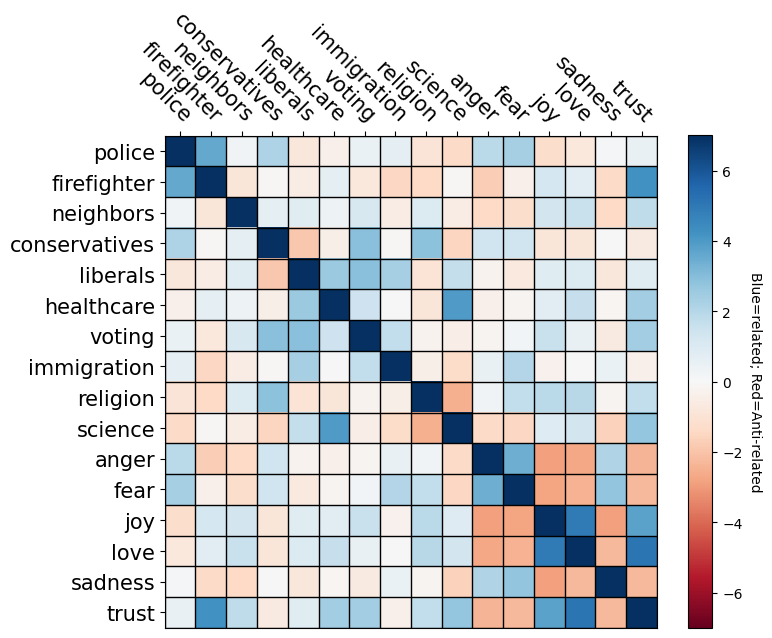

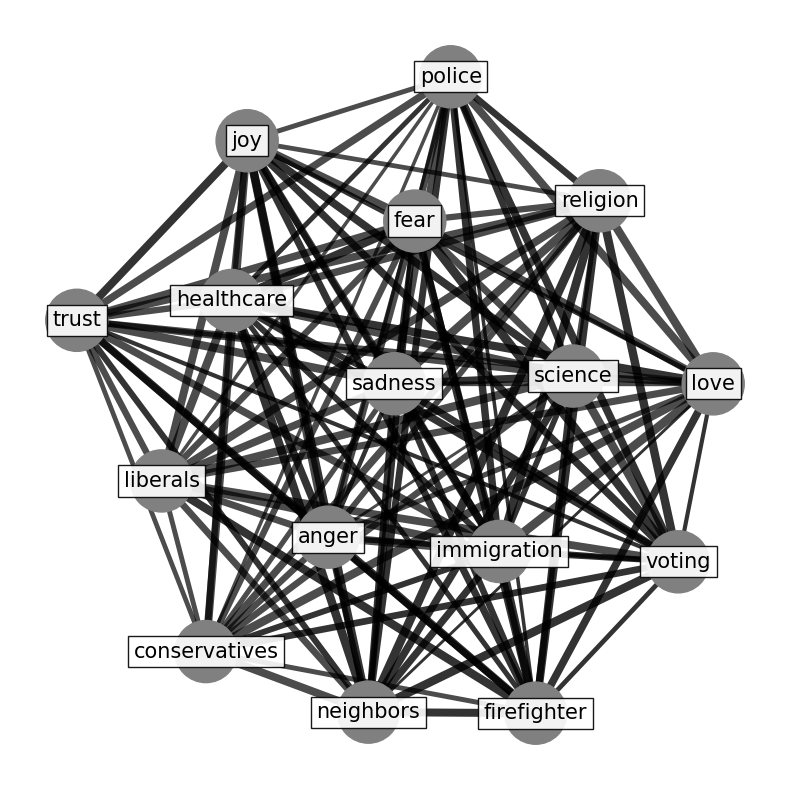

In [ ]:
# @title Figure 1 panel: (a) PRaM Schematic; (b) Heatmap of similarity ratings (c) Fully connected graph

#Create heat map of full sample [panel b]
words_trim = [re.sub("[\(].*?[\)]", "", w) for w in words]
PRaM_Weights = weightedHeatmap(avgDist, words_trim,1, '', 'Blue=related; Red=Anti-related')


#Create Fully-connected graph of associations [panel c]
PrAM_final = PrAM_final #This is in edge space
PrAM_meanEdge = PrAM_final.mean(axis=0)
#PrAM_meanEdge = (PrAM_mean - min(PrAM_mean)) / (max(PrAM_mean) - min(PrAM_mean)) #adjust range to be between 0 and 1
#PrAM_meanEdge = PrAM_meanEdge.reset_index(drop=True)
#PrAM_meanEdge = (PrAM_meanEdge + 0.01) *10 #add 0.1 to account for 0 and multiply edges by constant to aid with vizualization
conceptPairs = pd.Series(combinations_list)
conceptPairs_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs] #remove parenthetical text from nodes for easier reading

#Identify unique and overlapping edges between race and news
sigEdge_RNoverlap = np.logical_and(sigEdges_race, sigEdges_newsBias)
sigEdge_RaceUnq = np.logical_and(sigEdges_race, ~sigEdge_RNoverlap)
sigEdge_NewsUnq = np.logical_and(sigEdges_newsBias, ~sigEdge_RNoverlap)
sigEdges = np.logical_or(sigEdge_RaceUnq, sigEdge_NewsUnq)
sigEdges = np.logical_or(sigEdges, sigEdge_RNoverlap)

#Draw Graph for average participant
G = nx.Graph()
for e in range(len(conceptPairs_trim)):
  G.add_edge(conceptPairs_trim[e][0], conceptPairs_trim[e][1], weight = round(PrAM_meanEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'grey')
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options) #ADJUST LABELS HERE

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_RaceUnq = list(compress(EdgeList, sigEdge_RaceUnq))
EdgeList_NewsUnq = list(compress(EdgeList, sigEdge_NewsUnq))
EdgeList_RaceNewsOverlap = list(compress(EdgeList, sigEdge_RNoverlap))
EdgeList_nonSig = list(compress(EdgeList, ~sigEdges))

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 10 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_nonSig, width=edgewidth, alpha = 0.8) #draw all edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_RaceUnq, width=edgewidth, alpha = 0.7)#, edge_color="b") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_NewsUnq, width=edgewidth, alpha=0.7)#, edge_color="r") #draw news differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_RaceNewsOverlap, width=edgewidth, alpha=0.7)#, edge_color="purple") #draw news differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()

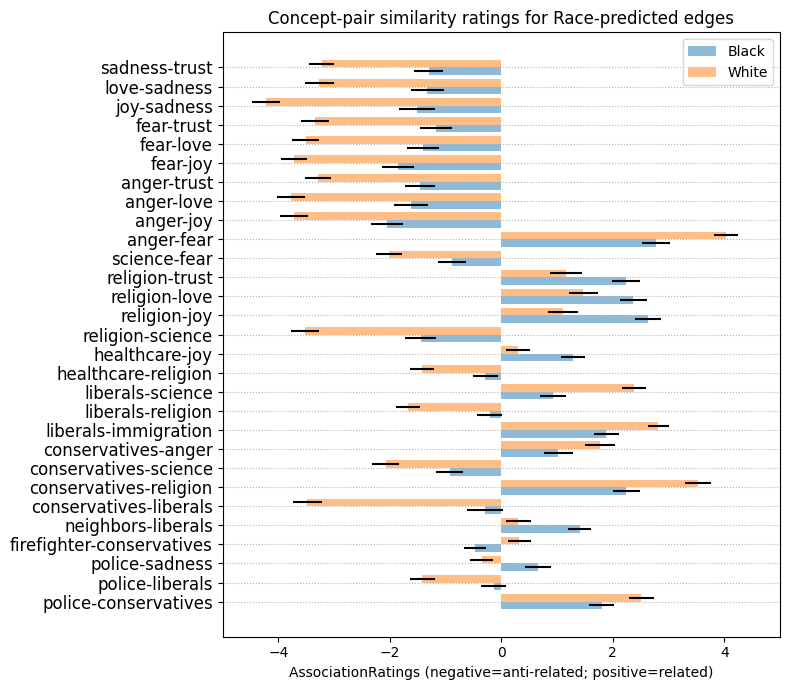

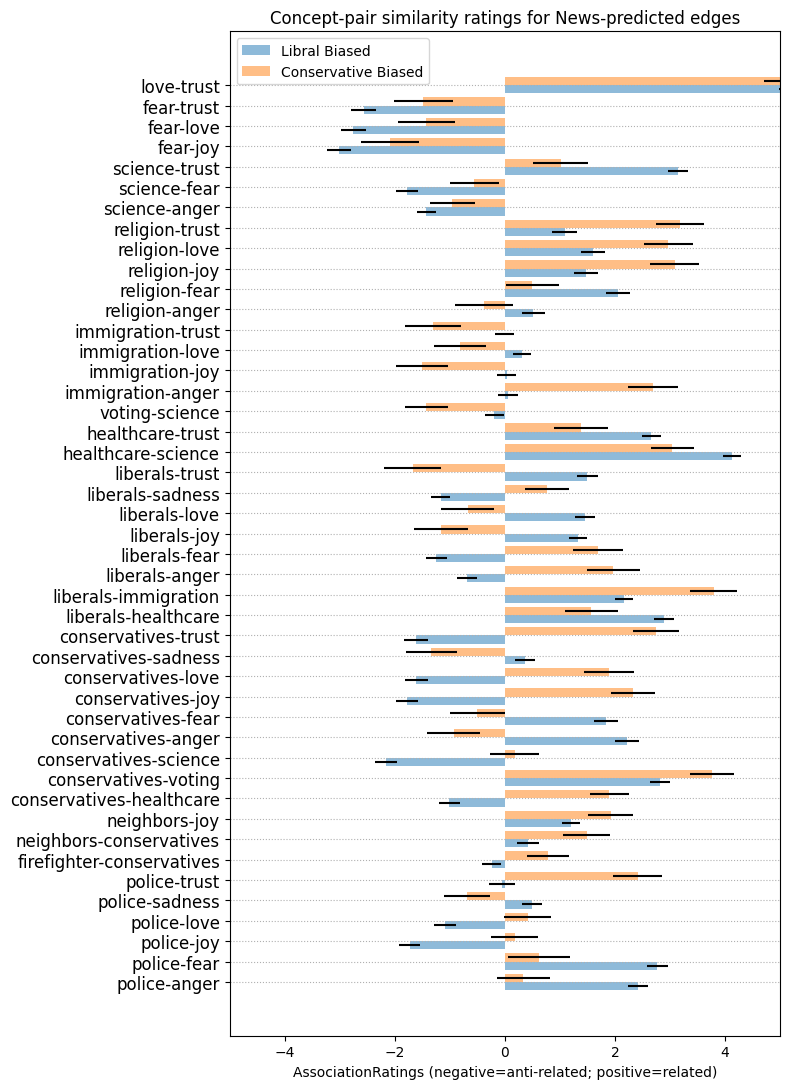

In [ ]:
# @title Vizualize Concept-pair Length Comparison for Significant Edges (This will also serve as the panel for Figure 2)

# Set bar width
bar_width = 0.4

#remove parentheticals
raceEdges_trim = [re.sub("[\(].*?[\)]", "", w) for w in raceEdges[0].values.tolist()]
newsEdges_trim = [re.sub("[\(].*?[\)]", "", w) for w in newsEdges[0].values.tolist()]

# Plot grouped bar chart with error bars
plt.rcParams["figure.figsize"] = [8, 7.0]
plt.rcParams["figure.autolayout"] = True
r1_race = np.arange(len(bfsePRaM_mean))
r2_race = [x + bar_width for x in r1_race]
fig, ax_race = plt.subplots()
ax_race.barh(r1_race, bfsePRaM_mean, xerr=bfsePRaM_SEM, height=bar_width, alpha=0.5, label='Black')
ax_race.barh(r2_race, wfsePRaM_mean, xerr=wfsePRaM_SEM, height=bar_width, alpha=0.5, label='White')
plt.title('Concept-pair similarity ratings for Race-predicted edges')
ax_race.set_yticks([r + bar_width / 2 for r in range(len(bfsePRaM_mean))])
ax_race.set_yticklabels(raceEdges_trim, rotation=0, size=12)
#ax_race.grid(which = "minor", axis='y', linestyle = "dashed")
#ax_race.minorticks_on()
ax_race.set_xlabel('AssociationRatings (negative=anti-related; positive=related)')
ax_race.legend()
plt.xlim([-5, 5])
ax_race.yaxis.grid(ls = 'dotted')
plt.show()


# Plot grouped bar chart with error bars
plt.rcParams["figure.figsize"] = [8, 11.0]
plt.rcParams["figure.autolayout"] = True
r1_news = np.arange(len(lfsePRaM_mean))
r2_news = [x + bar_width for x in r1_news]
fig, ax_news = plt.subplots()
ax_news.barh(r1_news, lfsePRaM_mean, xerr=lfsePRaM_SEM, height=bar_width, alpha=0.5, label='Libral Biased')
ax_news.barh(r2_news, rtsePRaM_mean, xerr=rtsePRaM_SEM, height=bar_width, alpha=0.5, label='Conservative Biased')
plt.title('Concept-pair similarity ratings for News-predicted edges')
ax_news.set_yticks([r + bar_width / 2 for r in range(len(lfsePRaM_mean))])
ax_news.set_yticklabels(newsEdges_trim, rotation=0, size = 12)
ax_news.set_xlabel('AssociationRatings (negative=anti-related; positive=related)')
ax_news.legend()
plt.xlim([-5, 5])
ax_news.yaxis.grid(ls = 'dotted')
plt.show()

In [ ]:
# @title Paper-relevant descriptive statistics
pd.set_option('mode.chained_assignment', None)
#Using data defined above
  # lfsePRaM_mean = lfPRaM_sigEdges.mean(axis=0)
  # rtsePRaM_mean = rtPRaM_sigEdges.mean(axis=0)
  # lfsePRaM_SEM = np.std(lfPRaM_sigEdges, axis=0)/np.sqrt(lfPRaM_sigEdges.shape[0])
  # rtsePRaM_SEM = np.std(rtPRaM_sigEdges, axis=0)/np.sqrt(rtPRaM_sigEdges.shape[0])

#Create data frame of labels, policital means, and SEM
newsDiffRatings = newsEdges
newsDiffRatings['LeftRatings'] = lfsePRaM_mean
newsDiffRatings['RightRatings'] = rtsePRaM_mean
newsDiffRatings['LeftSEM'] = lfsePRaM_SEM
newsDiffRatings['RightSEM'] = rtsePRaM_SEM

display(newsDiffRatings)


raceDiffRatings = raceEdges
raceDiffRatings['BlackRatings'] = bfsePRaM_mean
raceDiffRatings['WhiteRatings'] = wfsePRaM_mean
raceDiffRatings['BlackSEM'] = bfsePRaM_SEM
raceDiffRatings['WhiteSEM'] = wfsePRaM_SEM
display(raceDiffRatings)

,0,LeftRatings,RightRatings,LeftSEM,RightSEM
2,police-conservatives(political),2.464516,1.444444,0.201790,0.313908
9,police-anger,2.512903,0.410256,0.196363,0.348264
10,police-fear,2.832258,1.179487,0.198309,0.386154
11,police-joy,-1.945161,0.025641,0.207760,0.291216
12,police-love,-1.251613,0.316239,0.207918,0.298204
13,police-sadness,0.470968,-0.829060,0.197414,0.305618
14,police-trust,-0.245161,1.897436,0.243102,0.338743
16,firefighter-conservatives(political),-0.270968,0.256410,0.177192,0.281183
29,neighbors(yours)-conservatives(political),0.367742,1.179487,0.211680,0.310202
43,conservatives(political)-healthcare,-1.141935,1.230769,0.205840,0.277846


,0,BlackRatings,WhiteRatings,BlackSEM,WhiteSEM
2,police-conservatives(political),1.804082,2.512500,0.224401,0.222047
3,police-liberals(political),-0.138776,-1.416667,0.221286,0.220019
13,police-sadness,0.661224,-0.350000,0.228020,0.208691
16,firefighter-conservatives(political),-0.469388,0.325000,0.201081,0.201326
29,neighbors(yours)-conservatives(political),0.253061,1.029167,0.233129,0.225955
30,neighbors(yours)-liberals(political),1.404082,0.308333,0.212362,0.226736
42,conservatives(political)-liberals(political),-0.297959,-3.479167,0.319862,0.261536
46,conservatives(political)-religion,2.244898,3.529167,0.242275,0.228590
47,conservatives(political)-science,-0.922449,-2.075000,0.242008,0.245397
48,conservatives(political)-anger,1.024490,1.779167,0.259813,0.269171


The r between Black identity and convervative news consumption is: -0.068 (p= [0.0647] )


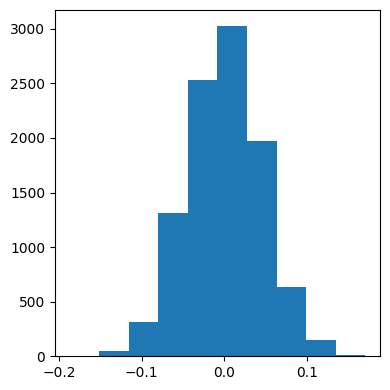

In [ ]:
# @title Establish correlational relationship between News Consumption and Racial Identity

# #Establish relationship between News and Black Identity
NewsBias = NewsBias.squeeze()
NewsBias = np.asarray(NewsBias, dtype=np.float64)
blackCoded = blackCoded.squeeze()


# Observed correlation
obsCorr_BN = np.corrcoef(NewsBias, blackCoded)

# Define the permutation count and data
perm = 10000
n_samples = len(NewsBias)  # Number of samples

# Convert News to a NumPy array for faster operations
news_array = np.array(NewsBias)

# Generate all permutations at once
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)])

# Generate all permuted versions of PrAM_final[80] in one go
yPermAll = np.array([blackCoded[perm] for perm in pComb])  # Shape: (10000, 485)

# Compute correlations
news_array = news_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(news_array, yPermAll)[0, 1:]  # Correlations between `news_array` and each row in `yPermAll`

# Convert to DataFrame
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"])

pval =[]
if obsCorr_BN[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_BN[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_BN[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_BN[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)

else:
  raise ValueError('observed beta is exactly equal to 0')

plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.hist(rPermDist)
print('The r between Black identity and convervative news consumption is:', round(obsCorr_BN[0][1],3), '(p=',pval,')')

In [ ]:
# @title Measure non-Race identity variables with News consumption [Something is weird with AGEDF and NewsBias_Cor]

#Compute Age correlation permutation
obsCorr_AN = np.corrcoef(Age, NewsBias)
print('Age/NewsConsumption r = ', obsCorr_AN[0][1])

# Define the permutation count and data
perm = 10000
n_samples = len(NewsBias)  # Number of samples

age_array = np.array(Age) # Convert Age to a NumPy array for faster operations
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)]) # Generate all permutations at once
yPermAll = np.array([NewsBias[perm] for perm in pComb])  # Shape: (10000, 485) # Generate all permuted versions in one go
age_array = age_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(age_array, yPermAll)[0, 1:]  # Correlations between `age_array` and each row in `yPermAll`
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"]) # Convert to DataFrame

pval =[]
if obsCorr_AN[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_AN[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_AN[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_AN[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')
print('  Age/NewsConsumption p-value = ', pval)


#Compute Income correlation permutation
Income_nGnANB_array = Income_nGnANB.to_numpy().squeeze()
Income_nGnANB_array = np.asarray(Income_nGnANB_array, dtype=np.float64)
obsCorr_IN = np.corrcoef(Income_nGnANB_array, NewsBias)
print('Income/NewsConsumption r = ', obsCorr_IN[0][1])

income_array = np.array(Income_nGnANB_array) # Convert Income to a NumPy array for faster operations
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)]) # Generate all permutations at once
yPermAll = np.array([NewsBias[perm] for perm in pComb])  # Shape: (10000, 485) # Generate all permuted versions in one go
income_array = income_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(income_array, yPermAll)[0, 1:]  # Correlations between `income_array` and each row in `yPermAll`
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"]) # Convert to DataFrame

pval =[]
if obsCorr_IN[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_IN[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_IN[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_IN[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')
print('  Income/NewsConsumption p-value = ', pval)


#Compute Gender correlation permutation
Gender_nGnANB_array = Gender_nGnANB.to_numpy().squeeze()
Gender_nGnANB_array = np.asarray(Gender_nGnANB_array, dtype=np.float64)
obsCorr_GN = np.corrcoef(Gender_nGnANB_array, NewsBias)
print('Gender/NewsConsumption r = ', obsCorr_GN[0][1])

gender_array = np.array(Gender_nGnANB_array) # Convert Income to a NumPy array for faster operations
pComb = np.array([np.random.permutation(n_samples) for _ in range(perm)]) # Generate all permutations at once
yPermAll = np.array([NewsBias[perm] for perm in pComb])  # Shape: (10000, 485) # Generate all permuted versions in one go
gender_array = gender_array.reshape(1, -1)  # Shape: (1, 485) to broadcast for correlation
rPermDist = np.corrcoef(gender_array, yPermAll)[0, 1:]  # Correlations between `gender_array` and each row in `yPermAll`
rPermDist = pd.DataFrame(rPermDist, columns=["Correlation"]) # Convert to DataFrame

pval =[]
if obsCorr_GN[0][1] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_GN[0][1])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_GN[0][1] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_GN[0][1]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')
print('  Gender/NewsConsumption p-value = ', pval)

Age/NewsConsumption r =  0.010384460984769455
  Age/NewsConsumption p-value =  [0.4149]
Income/NewsConsumption r =  -0.03158376652119757
  Income/NewsConsumption p-value =  [0.251]
Gender/NewsConsumption r =  -0.002793924095741273
  Gender/NewsConsumption p-value =  [0.4834]


In [ ]:
# @title Mediation analysis measuring effect of Black Identity (X) on Pair-distances (Yi) through News Consumption Bias (m)
warnings.filterwarnings('ignore')

#Use 10,000 iteration output (1 = yes; 0 = no)
use10000iter = 1

#Subset Mediation analysis by sig edges
PRaM_sigNewsEdges = PrAM_final.loc[:,sigEdges_newsBias]

#X: Black Identity
X_med = blackCoded.reshape(blackCoded.shape[0]) #adjust shape to fit

#m: News Consumption Bias
m_med = NewsBias

#Y: Pair data
Y_med = PRaM_sigNewsEdges.to_numpy()

#Loop through each pair and compute a permutation scrambling Y
ObsPairsPRaM_med = pd.DataFrame({'TotEff':[],'MedEff':[], 'DirEff':[], 'SumEff':[], 'SobelT':[]})
pPairsPRaM_med = pd.DataFrame({'Totpval':[],'Medpval':[], 'Dirpval':[], 'Sumpval':[], 'SobelTpval':[]})
perm = 10
#Iterate through concept-pairs
for i in tqdm(range(Y_med.shape[1])):
  # Isolate pair data
  yi = Y_med[:,i]
  #Dummy coded linear regression
  #Compared against permuted distribution
  medObs_PRaM, pval_PRaM = mediationPerm_v2(X_med, m_med, yi, perm)

  #Update output
  ObsPairsPRaM_med = pd.concat([ObsPairsPRaM_med,medObs_PRaM],ignore_index=True)
  pPairsPRaM_med = pd.concat([pPairsPRaM_med, pval_PRaM],ignore_index=True)

#Implement FDR correction

FDR_sigMed = []
import statsmodels as sm
for columnName, columnData in pPairsPRaM_med.items():
  FDR = sm.stats.multitest.fdrcorrection(columnData, alpha=0.05, method='indep', is_sorted=False)
  FDR_sigMed.append(FDR[0])
FDR_sigMed = pd.DataFrame(FDR_sigMed)

#Export data to CSV files
if use10000iter == 0:
  PrAM_save = pd.DataFrame(PRaM_nGnANB)
  FDR_sigMed.to_csv('FDRsigMed.csv')
  pPairsPRaM_med.to_csv('pPairsPRaM_med.csv')
  ObsPairsPRaM_med.to_csv('ObsPairsPRaM_med.csv')
  PrAM_save.to_csv('PRaM_finalModel_med.csv')
elif use10000iter == 1:
  FDR_sigMed = pd.read_csv (path + 'analysis/FDRsigMed_Ordinal_100000.csv', header=0, index_col=0)
  pPairsPRaM_med = pd.read_csv (path + 'analysis/pPairsPRaM_med_Ordinal_100000.csv', header=0, index_col=0)
  ObsPairsPRaM_med = pd.read_csv (path + 'analysis/ObsPairsPRaM_med_Ordinal_100000.csv', header=0, index_col=0)
  #PrAM_final = pd.read_csv (path + 'analysis/PRaM_finalModel_med_10000.csv', header=0, index_col=0)
  #PrAM_final = pd.DataFrame(PRaM_nGnANB)

100%|██████████| 50/50 [00:02<00:00, 21.18it/s]


Graph Centrality
police           0.21
conservatives    0.50
liberals         0.43
sadness          0.29
firefighter      0.07
neighbors        0.14
religion         0.50
science          0.29
anger            0.36
immigration      0.07
healthcare       0.21
joy              0.36
trust            0.36
love             0.29
fear             0.36
dtype: float64


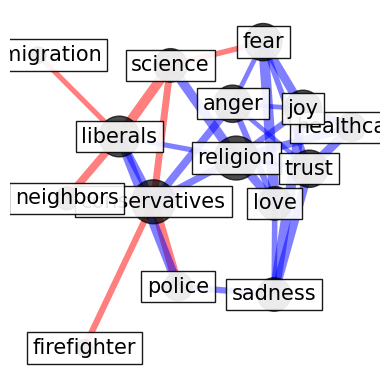

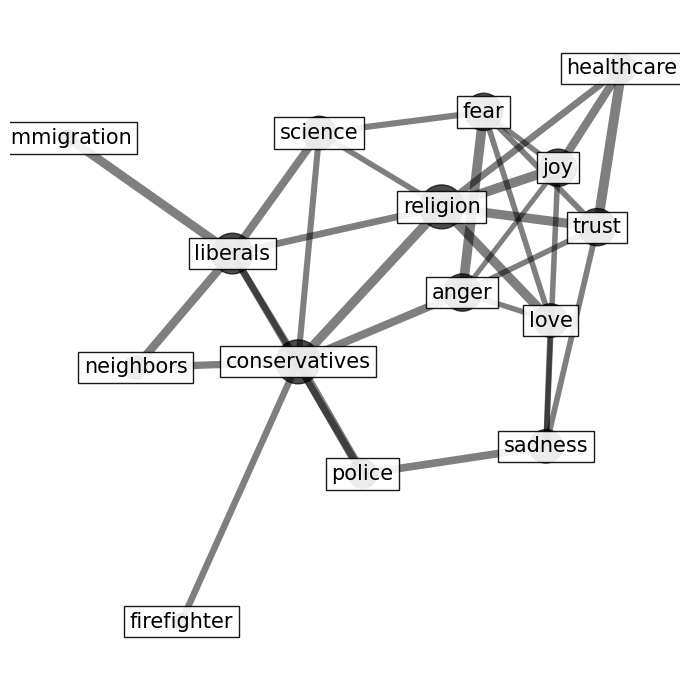

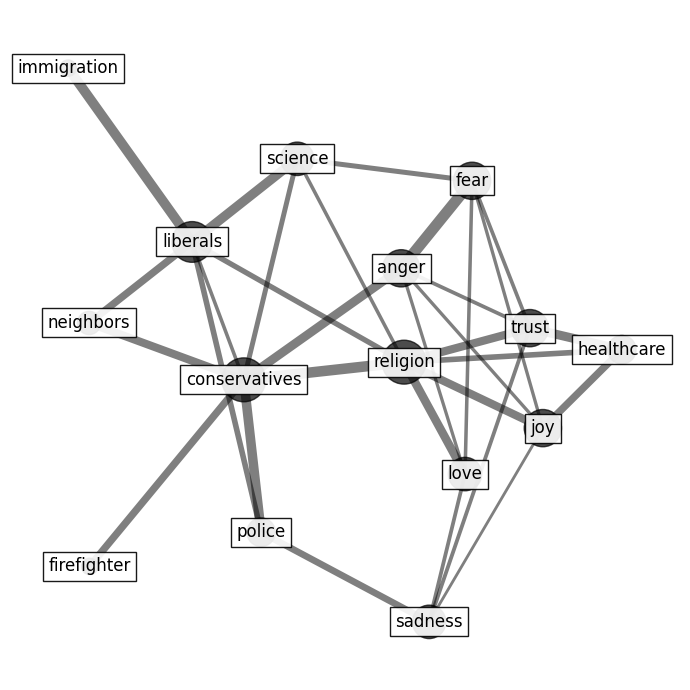

In [ ]:
# @title Figure 2: Group diff. Panel (a) Graph with racediffering edges. (b)bar graph (c) black graph (d) white graph

PrAM_final_reverse = (1 - PrAM_final)*2 #Reverse direction because networkx weights are such that high values meen shroter edges
seedn = 9
#Panel (a): Draw Graph for average participant
PrAM_finalRaceEdges = PrAM_final_reverse.loc[:,sigEdges_race] #This is in edge space
PrAM_meanRaceEdge = PrAM_finalRaceEdges.mean(axis=0)
PrAM_meanRaceEdge = PrAM_meanRaceEdge.reset_index(drop=True)

conceptPairs_race = pd.Series(list(compress(conceptPairs, sigEdges_race)))
conceptPairs_race = conceptPairs_race.reset_index(drop=True)
conceptPairsRace_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_race] #remove parenthetical text from nodes for easier reading


#Generate index of betas to reflect direction
raceBetas = bObsPairsPRaM['1']
raceBetas = raceBetas.loc[sigEdges_race]
raceBetas = raceBetas.reset_index(drop=True)
raceEdges_posBetas = raceBetas > 0 #Going from 0(white) to 1(black) results in an increase in edge distance
raceEdges_negBetas = raceBetas < 0 #Going from 0(white) to 1(black) results in an decrease in edge distance


G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_posBeta = list(compress(EdgeList, raceEdges_posBetas))
EdgeList_negBeta = list(compress(EdgeList, raceEdges_negBetas))


# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_posBeta, width=edgewidth, alpha = 0.5, edge_color="r") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_negBeta, width=edgewidth, alpha= 0.5, edge_color="b") #draw news differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()


#Panel (b): Use table of mean similarity differences by race-differing edges


#Panel (c): Same as a except use Black participant edges instead of group
PrAM_RaceEdges_blackp = PrAM_final_reverse.loc[bfIdx,sigEdges_race] #This is in edge space
PrAM_meanRaceEdges_blackp = PrAM_RaceEdges_blackp.mean(axis=0)
PrAM_meanRaceEdges_blackp = PrAM_meanRaceEdges_blackp.reset_index(drop=True)

G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdges_blackp[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="black") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()

#Panel (d): Graph of white partiicpants
PrAM_RaceEdges_whitep = PrAM_final_reverse.loc[wfIdx,sigEdges_race] #This is in edge space
PrAM_meanRaceEdges_whitep = PrAM_RaceEdges_whitep.mean(axis=0)
PrAM_meanRaceEdges_whitep = PrAM_meanRaceEdges_whitep.reset_index(drop=True)

G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdges_whitep[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=12, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="black") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()



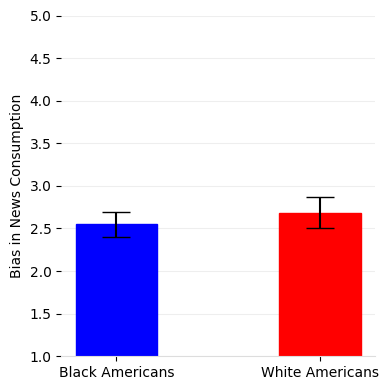

mean black news bias  2.55
mean white news bias  2.68
99CI black news bias  0.14
99CI white news bias  0.18
mean black news bias plus 1 CI(99%) is 2.69
mean white news bias minus 1 CI(99%) is 2.5
Graph Centrality
police           0.15
conservatives    0.46
sadness          0.15
firefighter      0.08
neighbors        0.08
religion         0.38
science          0.31
anger            0.15
liberals         0.15
immigration      0.08
joy              0.23
love             0.15
trust            0.23
fear             0.31
dtype: float64


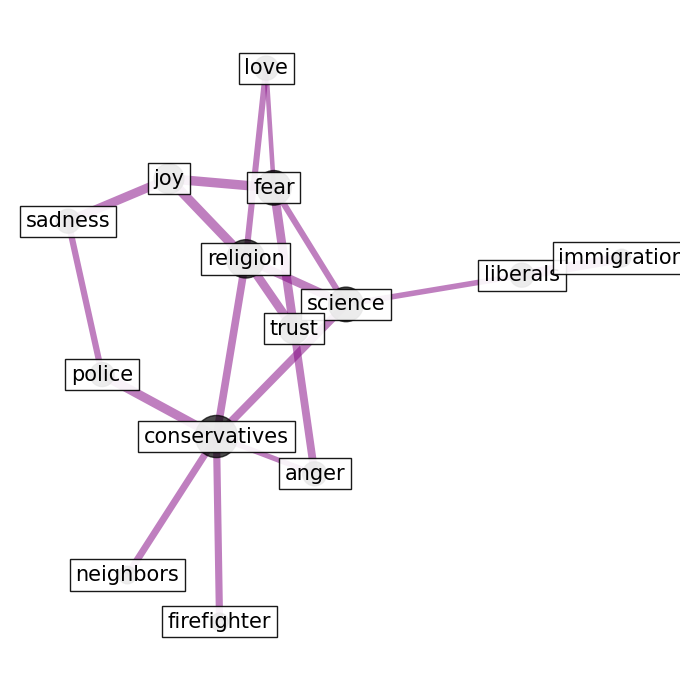

Graph Centrality
police           0.21
conservatives    0.50
liberals         0.43
sadness          0.29
firefighter      0.07
neighbors        0.14
religion         0.50
science          0.29
anger            0.36
immigration      0.07
healthcare       0.21
joy              0.36
trust            0.36
love             0.29
fear             0.36
dtype: float64


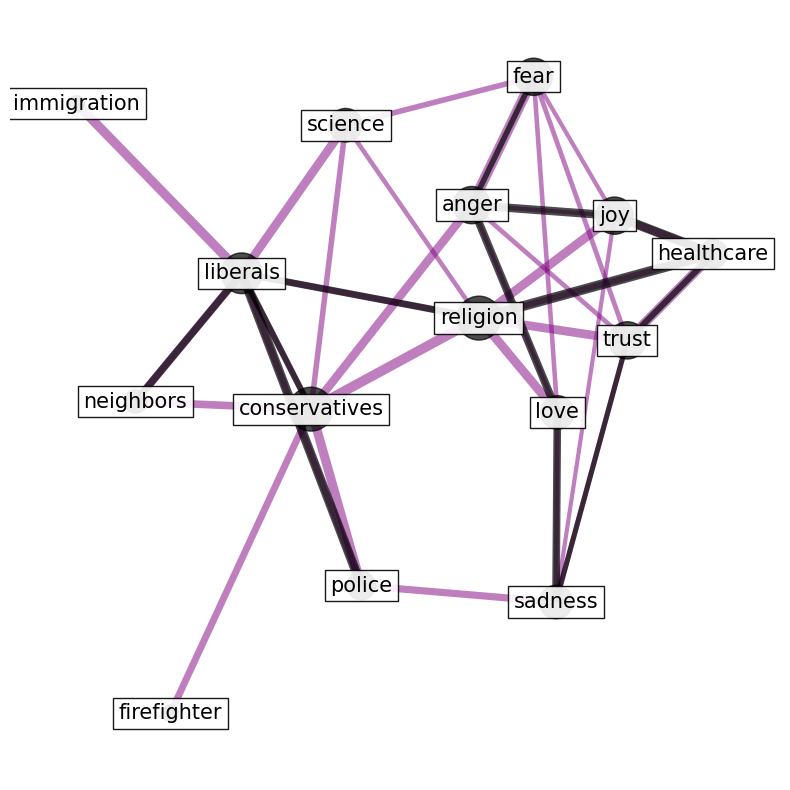

In [ ]:
# @title Figure 4: News bias diff Panel (a) Histogram of news bias both and individual racial groups. (b)bar graph showing mean and sd diff. (c) subgraph "Information" (indirect effects; ab[i.e., just mediated relationships]). (d) subgraph "Experience" (direct; c')


# Panel(a): histogram of political bias ratings



#Panel (b): Bar plot of political bias by group
bNewsBias = NewsBias_nGnANB[bIndx_nGnANB]
wNewsBias = NewsBias_nGnANB[wIndx_nGnANB]

bNewsBias_mean = bNewsBias.mean()
wNewsBias_mean = wNewsBias.mean()
bNewsBias_std = bNewsBias.std()
wNewsBias_std = wNewsBias.std()

bNewsBias_99CI = 	2.576*(bNewsBias_std/np.sqrt(len(bNewsBias)))
wNewsBias_99CI = 	2.576*(wNewsBias_std/np.sqrt(len(wNewsBias)))

barDat = {'Black Americans':bNewsBias_mean, 'White Americans':wNewsBias_mean}
groups = list(barDat.keys())
meanBias = list(barDat.values())
barSD = [bNewsBias_99CI, wNewsBias_99CI]

fig, ax = plt.subplots(figsize = (4, 4))
# xtick_loc = [1, 1.5]
# ax.set_xticks(xtick_loc)
bars = plt.bar(groups, meanBias, yerr=barSD, width = 0.4, capsize=10)
bars[0].set_color('b')
bars[1].set_color('r')
plt.ylim(1,5)
plt.ylabel("Bias in News Consumption")
plt.xticks
#plt.errorbar(fmt='o', markersize=8, capsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
plt.show()

print('mean black news bias ', round(bNewsBias_mean,2))
print('mean white news bias ', round(wNewsBias_mean,2))
print('99CI black news bias ', round(bNewsBias_99CI,2))
print('99CI white news bias ', round(wNewsBias_99CI,2))
print('mean black news bias plus 1 CI(99%) is', round(bNewsBias_mean+bNewsBias_99CI,2))
print('mean white news bias minus 1 CI(99%) is', round(wNewsBias_mean-wNewsBias_99CI,2))


#Panel (c): Subgraph of mediated effects !!!!!!!!!!!!!!!
PrAM_meanRaceEdge = PrAM_meanRaceEdge #Reversed (i.e. 1-OG edges) to be formatted for network x

#Get Booleans of Med and Direct effects
FDR_sigMedT = FDR_sigMed.transpose()
sigMediation = FDR_sigMedT[1]
sigDirect = FDR_sigMedT[2]
sigDirMed = pd.Series(list(compress(sigDirect, sigMediation)))
sigDirectUnq = pd.Series(list(compress(sigDirect, ~sigMediation)))
sigMediationUnq = pd.Series(list(compress(~sigDirMed, sigMediation)))

#Get full-set indicies of dir, med, and dir/med effects
newsSigIndex = [i for i, x in enumerate(sigEdges_newsBias) if x]
newsSigIndex_dir = list(compress(newsSigIndex, sigDirect))
newsSigIndex_med = list(compress(newsSigIndex, sigMediation))
newsSigIndex_dirMed = list(compress(newsSigIndex, sigDirMed))
newsSigIndex_dirUnq = list(compress(newsSigIndex, sigDirectUnq))
newsSigIndex_medUnq = list(compress(newsSigIndex, sigMediationUnq))

conceptPairs_newsDir = conceptPairs[newsSigIndex_dir]
conceptPairs_newsMed = conceptPairs[newsSigIndex_med]
# conceptPairs_newsDirMedUnq = conceptPairs[newsSigIndex_dirMed]
# conceptPairs_newsDirUnq = conceptPairs[newsSigIndex_dirUnq]
conceptPairs_newsMedUnq = conceptPairs[newsSigIndex_medUnq]

conceptPairs_newsDir = [(u,v) for (u,v) in conceptPairs_newsDir]
conceptPairs_newsMed = [(u,v) for (u,v) in conceptPairs_newsMed]
# conceptPairs_newsDirMedUnq = [(u,v) for (u,v) in conceptPairs_newsDirMedUnq]
# conceptPairs_newsDirUnq = [(u,v) for (u,v) in conceptPairs_newsDirUnq]
conceptPairs_newsMedUnq = [(u,v) for (u,v) in conceptPairs_newsMedUnq]

raceSigIndex = [i for i, x in enumerate(sigEdges_race) if x]
raceSigUnqEdges = [i for i in raceSigIndex if i not in newsSigIndex]
conceptPairs_unqRace = conceptPairs[raceSigUnqEdges]
conceptPairs_unqRace = [(u,v) for (u,v) in conceptPairs_unqRace]



#Trim strings to remove parantheses
# conceptPairs_race = pd.Series(list(compress(conceptPairs, sigEdges_race)))
# conceptPairs_race = conceptPairs_race.reset_index(drop=True)


#Set of racediffering concepts-pairs that are mediated by news
newsMedInRaceDiff = [i for i in newsSigIndex if i in raceSigIndex]
conceptPairs_newsMedInRace = conceptPairs[newsMedInRaceDiff]
conceptPairs_newsMedInRace = [(u,v) for (u,v) in conceptPairs_newsMedInRace]
conceptPairs_newsMedInRace_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_newsMedInRace] #remove parenthetical text from nodes for easier reading && #Use this edge list for panel c and for a purple set of edges in panel d


#Start drawing graph
G = nx.Graph()
for e in range(len(conceptPairs_newsMedInRace_trim)):
  G.add_edge(conceptPairs_newsMedInRace_trim[e][0], conceptPairs_newsMedInRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="purple") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()


#Panel (d): Subgraph of direct effects !!!!!!!!!!!!!!!!

#Set of racediffering concepts-pairs excluding those mediated by news
RaceDiffminusNewsMed = [i for i in raceSigIndex if i in newsSigIndex_medUnq]
RaceDiffminusNewsMed = [i for i in raceSigIndex if i not in RaceDiffminusNewsMed]
conceptPairs_RaceDiffminusNewsMed = conceptPairs[RaceDiffminusNewsMed]
conceptPairs_RaceDiffminusNewsMed = [(u,v) for (u,v) in conceptPairs_RaceDiffminusNewsMed] #Use this edge list for panel d [CORRECT]
conceptPairs_RaceDiffminusNewsMed_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_RaceDiffminusNewsMed]

RaceDiffUnqminusNewsMed = [i for i in raceSigIndex if i not in newsSigIndex]
conceptPairs_RaceDiffUnqminusNewsMed = conceptPairs[RaceDiffUnqminusNewsMed]
conceptPairs_RaceDiffUnqminusNewsMed = [(u,v) for (u,v) in conceptPairs_RaceDiffUnqminusNewsMed] #Use this edge list for panel d [Correct]
conceptPairs_RaceDiffUnqminusNewsMed_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_RaceDiffUnqminusNewsMed]

#Start drawing graph
G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

#Remove edges that are completely mediated by news consumption
  #conceptPairs_RaceDiffUnqminusNewsMed_trim
  #Try remove edge code

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_Med = [(u,v) for (u,v) in EdgeList if [u,v] in conceptPairs_RaceDiffminusNewsMed_trim  or [v,u] in conceptPairs_RaceDiffminusNewsMed_trim]
EdgeList_UnqDir= [(u,v) for (u,v) in EdgeList if [u,v] in conceptPairs_RaceDiffUnqminusNewsMed_trim  or [v,u] in conceptPairs_RaceDiffUnqminusNewsMed_trim]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_Med, width=edgewidth, alpha = 0.5, edge_color="purple") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_UnqDir, width=edgewidth, alpha = 0.7, edge_color="black") #draw race differing edges


#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()


In [ ]:
conceptPairs_newsMedInRace_trim

[['police', 'conservatives'],
 ['police', 'sadness'],
 ['firefighter', 'conservatives'],
 ['neighbors', 'conservatives'],
 ['conservatives', 'religion'],
 ['conservatives', 'science'],
 ['conservatives', 'anger'],
 ['liberals', 'immigration'],
 ['liberals', 'science'],
 ['religion', 'science'],
 ['religion', 'joy'],
 ['religion', 'love'],
 ['religion', 'trust'],
 ['science', 'fear'],
 ['anger', 'trust'],
 ['fear', 'joy'],
 ['fear', 'love'],
 ['fear', 'trust'],
 ['joy', 'sadness']]

In [ ]:
# @title List of race-differing edges completely mediated by news consumption
conceptPairs_Race = conceptPairs[raceSigIndex]
conceptPairs_Race = [(u,v) for (u,v) in conceptPairs_Race]
conceptPairs_Race

li1 = conceptPairs_Race
li2 = conceptPairs_RaceDiffminusNewsMed

s = set(li2)
temp3 = [x for x in li1 if x not in s]
temp3

[]

100%|██████████| 120/120 [00:00<00:00, 908.19it/s]


Parameters [1.80248913e+01 1.29945481e-02 2.86677732e+00]
CI: [[6.103364018600605, 29.946418605737275], [-0.08848062148890452, 0.11446971762097448], [2.409773219736944, 3.3237814238581387]]
RMSE: 0.19473727440518546
R-squared: 0.24006728161637447


100%|██████████| 120/120 [00:00<00:00, 38535.83it/s]


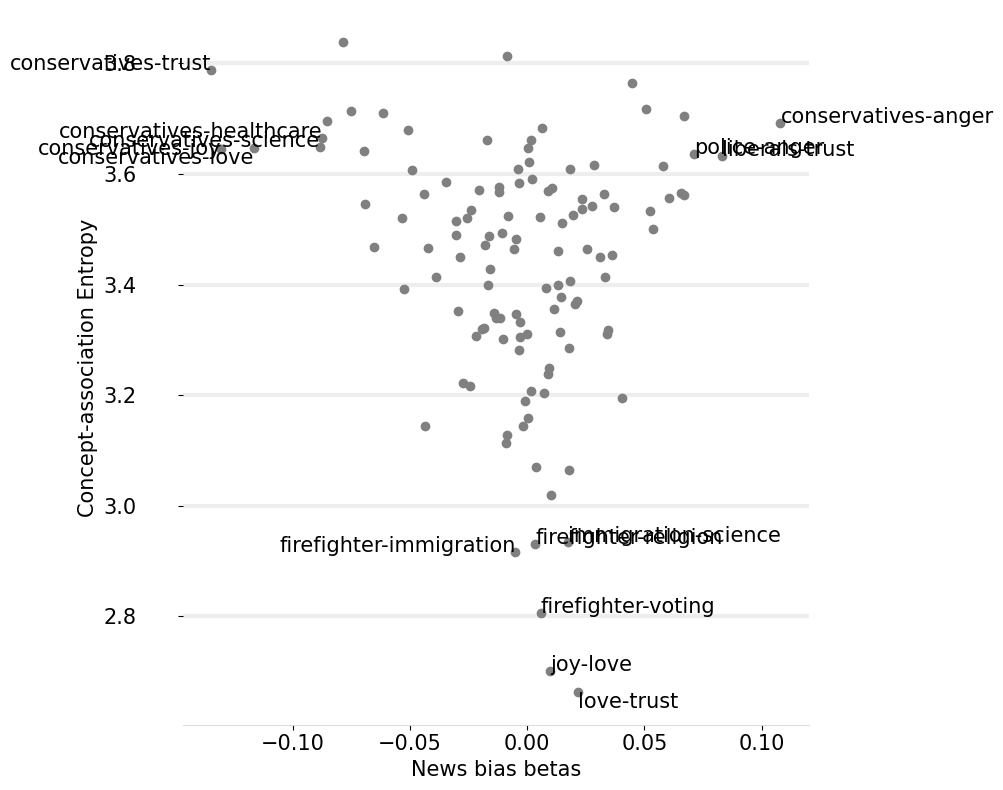

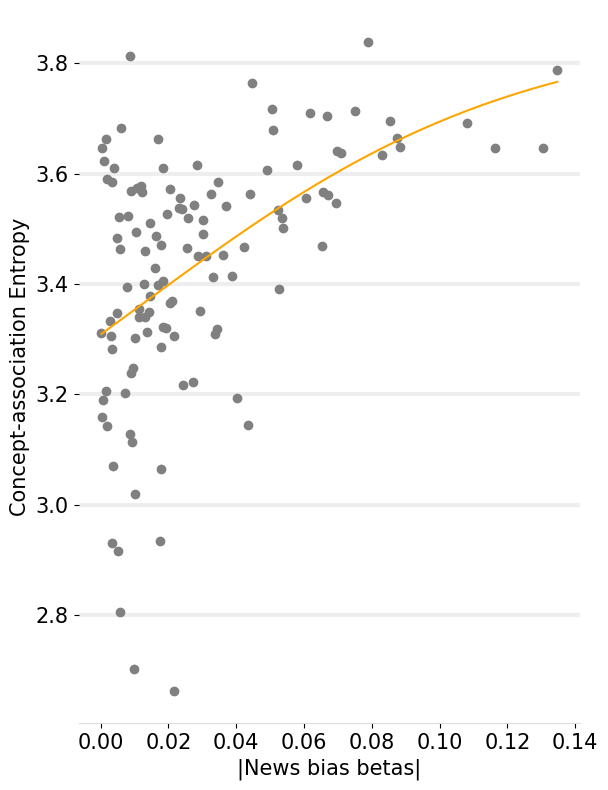

In [ ]:
# @title Figure 4: Edge entropy and news betas

#News predicting individal concept-pair edges
newsBetas = bObsPairsPRaM['5']

newsBetasAbs = np.absolute(newsBetas)
#Similarity data
PrAM_finalSim = PrAM_finalSim #cocnept-pairs in similarity space

#Shannon's entropy
base = 2  # work in units of bits

pairEntropy = []
for p in tqdm(range(len(PairLabel))):
  pairCounts = Counter(PrAM_finalSim[p])
  prop = []
  for c in pairCounts:
    propc = pairCounts[c]/PrAM_finalSim.shape[0]
    prop.append(propc)
  pk = prop
  H = entropy(pk, base=base)
  pairEntropy.append(H)

#Generate the line of best fit
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

newsBetasAbs = np.absolute(newsBetas)

xData = numpy.array(newsBetasAbs)
yData = numpy.array(pairEntropy)

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters)

absError = modelPredictions - yData

#Compute parameterwise CI
from scipy.stats import t
n = len(yData) #data points
p = len(fittedParameters) #number of parameters
alpha = 0.05

dof = max(0,n-p) #degrees of freedom
tval = t.ppf(1.0-alpha/2.,dof)
SE=[]
pint=[]
for i, p, var in zip(range(n), fittedParameters, np.diag(pcov)):
  sigma = var**0.5
  SE.append(sigma)
  pint.append([p-sigma*tval, p+sigma*tval])
print('CI:',pint)

#Report RMSE and Rsquard
SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)


#Generate Entropy Plots
#Threshold for labeling
bsd = np.std(newsBetas)
bmean = np.mean(newsBetas)
Thrbu = bmean + (1.8*bsd)
Thrbl = bmean - (2*bsd)
ThrMaskb = (newsBetas > Thrbu) | (newsBetas < Thrbl)

Hsd = np.std(pairEntropy)
Hmean = np.mean(pairEntropy)
ThrHu = Hmean + (1.9*Hsd)
ThrHl = Hmean - (1.9*Hsd)
ThrMaskH = (pairEntropy > ThrHu) | (pairEntropy < ThrHl)

combinedMask = ThrMaskb | ThrMaskH

pairLabelsScatter = []
for p in tqdm(range(len(PairLabel))):
  if combinedMask[p] == True:
    pairLabelsScatter.append(PairLabel[0][p])
  elif combinedMask[p] == False:
    pairLabelsScatter.append('')



#Plot Scatter plots
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetas, pairEntropy, c ='grey')
plt.xlabel("News bias betas", size=15)
plt.ylabel("Concept-association Entropy", size=15)

##add point labels
pairLabelsScatter_trim = [re.sub("[\(].*?[\)]", "", lab) for lab in pairLabelsScatter]
for i, txt in enumerate(pairLabelsScatter_trim):
  if (newsBetas[i] <= 0 and txt=='conservatives-love'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', ha='right', size=15)
  elif (newsBetas[i] <= 0 and txt=='conservatives-joy'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='center', ha='right', size=15)
  elif (newsBetas[i] <= 0 and txt=='liberals-anger'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='center', ha='right', size=15)
  elif (newsBetas[i] >= 0 and txt=='liberals-love'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', size=15)
  elif (newsBetas[i] >= 0 and txt=='love-trust'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', size=15)
  elif newsBetas[i] >= 0:
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), size=15)
  elif newsBetas[i] < 0:
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), ha='right', size=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', pad=30)
plt.show()


#Plot absolute value plot
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetasAbs,pairEntropy, c ='grey')
plt.xlabel("|News bias betas|", size=15)
plt.ylabel("Concept-association Entropy", size=15)
# for i, txt in enumerate(pairLabelsScatter):
#   ax.annotate(txt, (newsBetasAbs[i], pairEntropy[i]))

#plt.annotate("R2 = {:.3f}".format(Rsquared), (0.06, 3.85), size=15)

# now the model as a line plot
xModel = numpy.linspace(min(xData), max(xData))
yModel = func(xModel, *fittedParameters)
ax.plot(xModel, yModel, color='orange')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

100%|██████████| 120/120 [00:00<00:00, 99844.57it/s]


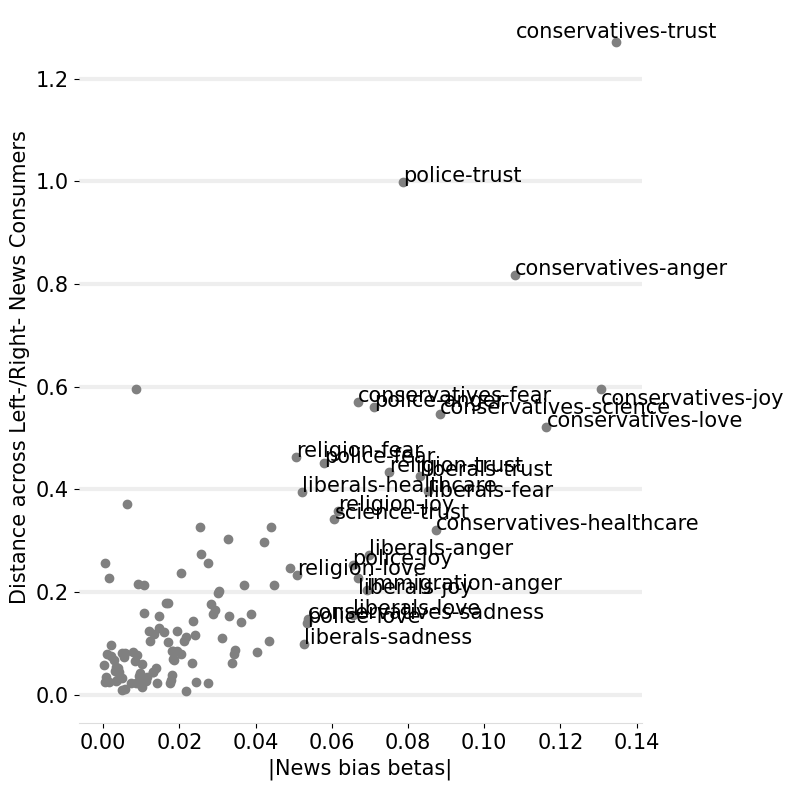

In [ ]:
# @title Representational distance by news bias effect (SI)
pairR = []

for p in tqdm(range(len(PairLabel))):
  lf = Counter(lfPRaM[p])
  rt = Counter(rtPRaM[p])

  tabulateRating = pd.DataFrame({'-7':[],'-6':[], '-5':[], '-4':[], '-3':[], '-2':[], '-1':[], '0':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[]})
  tabulateRating.loc[len(tabulateRating.index)] = [lf[-7], lf[-6], lf[-5], lf[-4], lf[-3], lf[-2], lf[-1], lf[0], lf[1], lf[2], lf[3], lf[4], lf[5], lf[6], lf[7]]
  tabulateRating.loc[len(tabulateRating.index)] = [rt[-7], rt[-6], rt[-5], rt[-4], rt[-3], rt[-2], rt[-1], rt[0], rt[1], rt[2], rt[3], rt[4], rt[5], rt[6], rt[7]]
  input = tabulateRating.transpose()
  r = np.corrcoef(input[0],input[1])
  pairR.append(1-r[0][1])

#Plot absolute value plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetasAbs,pairR, c ='grey')
plt.xlabel("|News bias betas|", size=15)
plt.ylabel("Distance across Left-/Right- News Consumers", size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)



#Threshold for labeling
bsd = np.std(newsBetas)
bmean = np.mean(newsBetas)
Thrbu = bmean + (1.8*bsd)
Thrbl = bmean - (2*bsd)
ThrMaskb = (newsBetas > Thrbu) | (newsBetas < Thrbl)

Hsd = np.std(pairR)
Hmean = np.mean(pairR)
ThrHu = Hmean + (1.9*Hsd)
ThrHl = Hmean - (1.9*Hsd)
ThrMaskH = (pairR > ThrHu) | (pairR < ThrHl)

combinedMask = ThrMaskb | ThrMaskH
combinedMask = (np.array(pairR) > 0.6) | (np.array(newsBetasAbs) > 0.05)

pairLabelsScatter = []
for p in tqdm(range(len(PairLabel))):
  if combinedMask[p] == True:
    pairLabelsScatter.append(PairLabel[0][p])
  elif combinedMask[p] == False:
    pairLabelsScatter.append('')

#trim parantheses
pairLabelsScatter_trim = [re.sub("[\(].*?[\)]", "", lab) for lab in pairLabelsScatter]

for i, txt in enumerate(pairLabelsScatter_trim):
  if (pairR[i] >= 0 and txt=='conservatives-joy'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='top', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='liberals-joy'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='top', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='liberals-fear'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='center', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='conservatives-immigration'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='center', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='conservatives-trust'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='bottom', ha='center', size=15)
  elif pairR[i] >= 0.6:
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), size=15)
  elif newsBetasAbs[i] > 0.05:
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), size=15) #, ha='right'
plt.show()